<h1>Содержание<span class="tocSkip"></span></h1>
</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-предобработке-данных" data-toc-modified-id="Вывод-по-предобработке-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод по предобработке данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Модель-градиентного-бустинга---CatBoost" data-toc-modified-id="Модель-градиентного-бустинга---CatBoost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель градиентного бустинга - CatBoost</a></span></li><li><span><a href="#Вывод-по-этапу-обучения-моеделей" data-toc-modified-id="Вывод-по-этапу-обучения-моеделей-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Вывод по этапу обучения моеделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Тест-на-адекватность-моделей-(Создание-константной-модели)" data-toc-modified-id="Тест-на-адекватность-моделей-(Создание-константной-модели)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Тест на адекватность моделей (Создание константной модели)</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [2]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import nltk 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer 
import re 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import catboost as cb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import catboost as cb

In [3]:
#Выгружаем данные
try: 
    df = pd.read_csv('/datasets/toxic_comments.csv')
except: 
    df = pd.read_csv('datasets/toxic_comments.csv')

In [4]:
#Просмотрим данные
display(df.head(10))
df.info()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
#Объявим корпус текстов
corpus = df['text'].values
print(corpus[0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [6]:
#Объявим лемматизатор и функцию для очистки и лемматизации текстов "clear_text":
wnl = WordNetLemmatizer()

def clear_text(text):
    pattern = re.sub(r'[^a-zA-Z]', ' ', text)
    clear = pattern.split()
    lemm = []
    for i in range(len(clear)):
        lemm.append(wnl.lemmatize(clear[i]))
    return " ".join(lemm)

In [7]:
#В цикле применим функцию для очистки и лемматизации текстов "clear_text":
for i in tqdm(range(len(corpus))):
    corpus[i] = clear_text(corpus[i])

100%|██████████| 159292/159292 [00:37<00:00, 4291.17it/s]


In [8]:
#Объединим датасет и корпус:
df_corpus = pd.DataFrame(corpus)
df['lemm_text'] = df_corpus[0]
display(df.head(10))
df.info()

,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation Why the edits made under my userna...,0,Explanation Why the edits made under my userna...
1,1,D aww He match this background colour I m seem...,0,D aww He match this background colour I m seem...
2,2,Hey man I m really not trying to edit war It s...,0,Hey man I m really not trying to edit war It s...
3,3,More I can t make any real suggestion on impro...,0,More I can t make any real suggestion on impro...
4,4,You sir are my hero Any chance you remember wh...,0,You sir are my hero Any chance you remember wh...
5,5,Congratulations from me a well use the tool we...,0,Congratulations from me a well use the tool we...
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,7,Your vandalism to the Matt Shirvington article...,0,Your vandalism to the Matt Shirvington article...
8,8,Sorry if the word nonsense wa offensive to you...,0,Sorry if the word nonsense wa offensive to you...
9,9,alignment on this subject and which are contra...,0,alignment on this subject and which are contra...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
 3   lemm_text   159292 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.9+ MB


0    143106
1     16186
Name: toxic, dtype: int64


<AxesSubplot:xlabel='toxic', ylabel='count'>

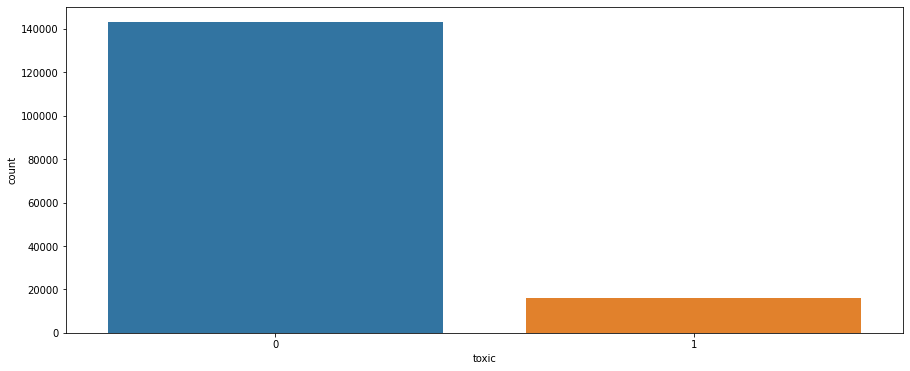

In [9]:
#Определим количество объектов мажорного и минорного классов и для наглядности строим график:
print(df['toxic'].value_counts())
zeroes = df['toxic'].value_counts()[0]
ones = df['toxic'].value_counts()[1]

plt.figure(figsize=(15, 6))
sns.countplot(x='toxic', data=df)

In [10]:
#Определяем признаки и целевой признак, разделяем датасет на тренировочную и тестовую выборки:
features = df['lemm_text']
target = df['toxic']

features_train_1, features_test_1, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42, stratify = target)

In [11]:
#Сделаем стоп-слова и векторизацию текста:
try:
    nltk.download('stopwords')
except:
    pass
#Объявляю набор стоп-слов 
try:
    stopwords = set(stopwords.words('english'))
except:
    pass
#Объявляю TFIDF-векторизатор
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
#Выполняю векторизацию текстов
features_train = count_tf_idf.fit_transform(features_train_1)
features_test = count_tf_idf.transform(features_test_1)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
#Оцениваем результаты:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(119469, 138262)
(39823, 138262)
(119469,)
(39823,)


**Отдельно слелаем набор фичей и таргетов для обучения CatBoost с меньшим количеством**

In [13]:
features_train_cb = features_train_1[:900]
features_test_cb = features_test_1[:300]
target_train_cb = target_train[:900]
target_test_cb = target_test[:300]

In [14]:
try:
    nltk.download('stopwords')
except:
    pass
#Объявляю набор стоп-слов 
try:
    stopwords = set(stopwords.words('english'))
except:
    pass
#Объявляю TFIDF-векторизатор
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
#Выполняю векторизацию текстов
features_train_cb = count_tf_idf.fit_transform(features_train_cb)
features_test_cb = count_tf_idf.transform(features_test_cb)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
print(features_train_cb.shape)
print(features_test_cb.shape)
print(target_train_cb.shape)
print(target_test_cb.shape)

(900, 7417)
(300, 7417)
(900,)
(300,)


### Вывод по предобработке данных
На первом этапе произведена загрузка данных и их подготовка для обучения моделей. Для анализа данных и построения модели предоставлен датасет с размеченными данными, содержащий комментарии пользователей к товарам, доступным для приобретения в интернет-магазине «Викишоп». Датасет состоит из 2 столбцов с данными и 159571 строк. Исходный датасет состоит из следующих столбцов:

* *text* — текст комментария;

* *toxic* — является ли комментарий токсичным (1) или нет (0)

* Пропуски в данных отсутствуют.

После открытия датасета и ознакомления с общей информацией объявлен корпус текстов. Затем тексты были очищены и лемматизированы. Проверка соотношения классов показала, что в датасете имеет место явный дисбаланс. Мажорный класс составляет лишь 10% от всего датасета. Следовательно этот аспект необходимо будет учесть в дальнейшем при обучении моделей. Для векторизации текстов был использован TfidfVectorizer(). После векторизации датасет образовал матрицу размером 159571 строк на 164272 столбцов.

В итоге полученный датасет разделен на обучающую и тестовые выборки в соотношении 4:1. Можно приступать к обучению моделей.

## Обучение

*В качестве моделей будем использовать Логистическую регрессию, Случайный лес и CatBoost классификатор.*

### Логистическая регрессия

In [21]:
%%time
#Обучаю и проверяю Логистическую регрессию на кросс-валидации, указываю параметр class_weight = 'balanced'
regression = LogisticRegression(fit_intercept=True, 
                                class_weight='balanced', 
                                random_state=42,
                                solver='liblinear'
                               )
#Определяю словарь с набором параметров
regression_parametrs = {'C': [0.1, 1, 10]}

#Применяю GridSearchCV с кросс-валидацией
regression_grid = GridSearchCV(regression, regression_parametrs, scoring='f1', cv=3)
regression_grid.fit(features_train, target_train)

regression.fit(features_train, target_train)
regression_cv_score = cross_val_score(regression,features_train, target_train,scoring='f1',cv=3).mean()
print('Среднее качество модели Логистической регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели Логистической регрессии на кросс-валидации: 0.7481180673684099
CPU times: user 51.3 s, sys: 1min 29s, total: 2min 20s
Wall time: 2min 21s


In [22]:
%%time
#Определяем оптимальные гиперпараметры и качество модели на кросс-валидации:
regression_params = regression_grid.best_params_
regression_score = regression_grid.score(features_train, target_train)
print(regression_params)
print(regression_score)
print('_______________')

{'C': 10}
0.9181897632708895
_______________
CPU times: user 40.4 ms, sys: 2.09 ms, total: 42.5 ms
Wall time: 41 ms


### Случайный лес

In [20]:
%%time
#Подбираю оптимальные гиперпараметры для Случайного леса на кросс-валидации, указываю параметр class_weight = 'balanced'
forest = RandomForestClassifier(class_weight='balanced', n_jobs=-1 )
#Определяю словарь с набором параметров
forest_parametrs = { 'n_estimators': range(20, 40, 5),
                     'max_depth': range(4, 8, 2),
                     'min_samples_leaf': range(3,5),
                     'min_samples_split': range(2,6,2)}

#Применяю GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(forest, forest_parametrs, scoring='f1', cv=3)
forest_grid.fit(features_train, target_train)

CPU times: user 3min 20s, sys: 5.09 s, total: 3min 25s
Wall time: 3min 26s


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1),
             param_grid={'max_depth': range(4, 8, 2),
                         'min_samples_leaf': range(3, 5),
                         'min_samples_split': range(2, 6, 2),
                         'n_estimators': range(20, 40, 5)},
             scoring='f1')

In [22]:
%%time
#Определяем оптимальные гиперпараметры и качество модели на кросс-валидации:
forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train, target_train)
print(forest_params)
print(forest_score)
print('_______________')

{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 35}
0.29996352228788215
_______________
CPU times: user 687 ms, sys: 14.2 ms, total: 701 ms
Wall time: 700 ms


In [24]:
%%time
#Обучаем модель Случайного леса на оптимальных гиперпараметрах:

forest_model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced',
                                     max_depth=forest_params['max_depth'],
                                     min_samples_leaf = forest_params['min_samples_leaf'],
                                     min_samples_split = forest_params['min_samples_split'],
                                     n_estimators = forest_params['n_estimators'])

forest_model.fit(features_train, target_train)

CPU times: user 696 ms, sys: 14.7 ms, total: 711 ms
Wall time: 710 ms


RandomForestClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=4,
                       min_samples_split=4, n_estimators=35, n_jobs=-1,
                       random_state=42)

### Модель градиентного бустинга - CatBoost

In [16]:
%%time

#Объявляю модель с учетом дисбаланса классов
cb = cb.CatBoostClassifier(class_weights=[1, zeroes/ones], iterations=30)
#Определяю словарь с набором параметров
cb_parametrs = {'depth': [4, 8]}

cb_grid = GridSearchCV(cb, cb_parametrs, scoring='f1', cv=3)
cb_grid.fit(features_train_cb, target_train_cb, verbose=10)

Learning rate set to 0.206388
0:	learn: 0.6850913	total: 60ms	remaining: 1.74s
10:	learn: 0.5262648	total: 168ms	remaining: 290ms
20:	learn: 0.4494319	total: 280ms	remaining: 120ms
29:	learn: 0.3847356	total: 377ms	remaining: 0us
Learning rate set to 0.206388
0:	learn: 0.6492229	total: 14.4ms	remaining: 419ms
10:	learn: 0.5347738	total: 133ms	remaining: 230ms
20:	learn: 0.4725138	total: 264ms	remaining: 113ms
29:	learn: 0.3940579	total: 371ms	remaining: 0us
Learning rate set to 0.206388
0:	learn: 0.6815340	total: 14.1ms	remaining: 410ms
10:	learn: 0.5453773	total: 133ms	remaining: 229ms
20:	learn: 0.4835644	total: 252ms	remaining: 108ms
29:	learn: 0.4307988	total: 362ms	remaining: 0us
Learning rate set to 0.206388
0:	learn: 0.6543050	total: 96.9ms	remaining: 2.81s
10:	learn: 0.4535442	total: 744ms	remaining: 1.28s
20:	learn: 0.3813252	total: 1.39s	remaining: 596ms
29:	learn: 0.3046501	total: 1.98s	remaining: 0us
Learning rate set to 0.206388
0:	learn: 0.6381994	total: 111ms	remaining: 

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f6535009670>,
             param_grid={'depth': [4, 8]}, scoring='f1')

In [17]:
%%time
#Определяем оптимальные гиперпараметры и качество модели на кросс-валидации:

cb_params = cb_grid.best_params_
cb_score = cb_grid.score(features_train_cb, target_train_cb)
print(cb_params)
print(cb_score)
print('_______________')

{'depth': 8}
0.8316831683168318
_______________
CPU times: user 12.5 ms, sys: 3.97 ms, total: 16.5 ms
Wall time: 14.8 ms


In [18]:
%%time
#Обучаем модель на оптимальных гиперпараметрах

cb_model = cb.CatBoostClassifier(class_weights=[1, zeroes/ones], depth=cb_params['depth'], iterations=50)
cb_model.fit(features_train_cb, target_train_cb, verbose=10)

Learning rate set to 0.153617
0:	learn: 0.6706149	total: 145ms	remaining: 7.09s
10:	learn: 0.5379942	total: 1.1s	remaining: 3.9s
20:	learn: 0.4592597	total: 2.06s	remaining: 2.84s
30:	learn: 0.3959669	total: 3.01s	remaining: 1.85s
40:	learn: 0.3454275	total: 3.98s	remaining: 873ms
49:	learn: 0.2925621	total: 4.88s	remaining: 0us
CPU times: user 4.92 s, sys: 56.4 ms, total: 4.97 s
Wall time: 5.34 s


### Вывод по этапу обучения моеделей

Для тестирования модели нам необходимо выбрать на этапе обучения лучшую модель, обученную с лучшими гиперпараметрами. Такой моделью в нашем исследовании является модель градиентного бустинга - CatBoost, однако в виду того, что работа с ней постоянно крашит ядро, а также её неадекватного поведения на тестовой выборке, лучше взять модель линейной регрессии, она тоже имеет качество выше 0,75 что удовлетворяет требованию задания.

## Тестирование

### Тест на адекватность моделей (Создание константной модели)

In [38]:
#Для надлежащей проверки моделей на адекватность создадим константную модель, данные константной модели будут набором единиц.
const_model = [1 for i in range(len(target_test))]
const_f1 = f1_score(target_test.reset_index(drop=True), const_model)
print(const_f1)

0.18445827349609065


In [23]:
%%time

regression_model = LogisticRegression(fit_intercept=True,
                                class_weight='balanced',
                                random_state=42,
                                solver='liblinear',
                                C=regression_params['C']
                               )

regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)

CPU times: user 9.34 s, sys: 15.7 s, total: 25 s
Wall time: 25 s


In [24]:
regression_predictions = regression_model.predict(features_test)
regression_f1 = round(f1_score(target_test, regression_predictions), 3) 
print(regression_f1)

0.762


## Выводы

На первом этапе произведена загрузка данных и их подготовка для обучения моделей. 
Для анализа данных и построения модели предоставлен датасет с размеченными данными, содержащий комментарии пользователей к товарам, доступным для приобретения в интернет-магазине «Викишоп». Датасет состоит из 2 столбцов с данными и 159571 строк. 
Затем тексты комментариев были очищены и лемматизированы. 
Проверка соотношения классов показала, что в датасете имеет место явный дисбаланс. Мажорный класс составляет лишь 10% от всего датасета. 
После векторизации датасет образовал матрицу размером 159571 строк на 164272 столбцов. В итоге полученный датасет разделен на обучающую и тестовые выборки в соотношении 4:1.

В качестве моделей использованы Логистическая регрессия, Случайный лес и CatBoost классификатор. 
По результатам подбора гиперпараметров и обучения моделей наилучший результат показал CatBoost классификатор (однако, он не был выбран для тестирования, об этом подробнее ниже), наихудший - Случайный лес. 

Все выбранные модели прошли проверку на адекватность в сравнении с константной моделью. Стоит отметить, что CatBoost классификатор выполняет расчеты в десятки раз дольше, нежели Логистическая регрессия, полученное при этом значение метрики f1 ниже, чем у Логистической регрессии, возможно при увеличении количества итераций мы получим результат, который будет стремиться к логистической регрессии и может быть f1-метрика будет даже больше, но и количество времени на обучение в виду этого будет затрачено колоссальное.

В связи с этим модели Логистическая регрессия и CatBoost классификатор подходят для решения поставленной задачи. Однако, для экономии времени и вычислителной мощности Логистическая регрессия является оптимальным решением для данной задачи.    